# This notebook can be used to prepare visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from copy import deepcopy
from typing import Tuple, Union, List, Any
from tqdm import tqdm
import sys
import torch
from torchvision.transforms import functional
from pytorch_model_summary import summary

In [3]:
from biomedical_image_segmentation.elastic_deform import custom_2d_elastic_deform
from biomedical_image_segmentation.data.validator import validate
from biomedical_image_segmentation.data.utils import CustomDataset, image_transformations, mask_transformations, process_output
from biomedical_image_segmentation.utils import load_pickle, create_dir
from biomedical_image_segmentation.models.custom_unet import CustomUNet
from biomedical_image_segmentation.plot_utils import insert_grid

In [4]:
PROJECT_PATH = os.getcwd().replace("notebooks","")
DATA_PATH = os.path.join(PROJECT_PATH, "data")
SAMPLES_PATH = os.path.join(DATA_PATH, "samples")
TRAIN_SAMPLES_PATH = os.path.join(SAMPLES_PATH, "train")
MASKS_PATH = os.path.join(DATA_PATH, "masks")
TRAIN_MASKS_PATH = os.path.join(MASKS_PATH, "train")

RESULTS_PATH = os.path.join(PROJECT_PATH, "results")
AUGMENTED_DATA_PATH = os.path.join(DATA_PATH, "augmented")
VALID_DATA_PATH = os.path.join(DATA_PATH, "valid")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test")

# to save all models
MODELS_PATH = os.path.join(DATA_PATH, "model-weights")

MODEL_NAME = "unet-700-manual-weighted-pixels1"
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME)

METRICS_NAME = f"{MODEL_NAME}-metrics"


OUTPUT_THRESHOLD = .5
DEVICE = "cpu"

In [5]:
create_dir(RESULTS_PATH)

In [6]:
ALPHA_AFFINE = (.01, .2)
SIGMA = 12.
ALPHA = 120.

In [7]:
test_dataset = load_pickle(os.path.join(TEST_DATA_PATH, "test.pickle"))
print(f"Total samples in test dataset: {len(test_dataset)}")

Total samples in test dataset: 5


In [8]:
i = 2
img, mask = test_dataset[i] 

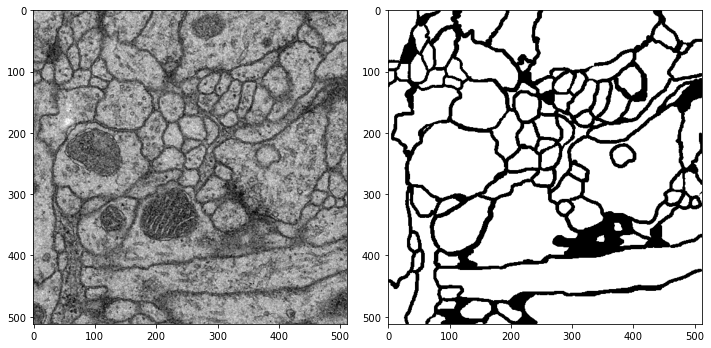

In [12]:
figname = "Test Image and Segmentation Mask without Grid"
figname = os.path.join(RESULTS_PATH, f"{figname}.png")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(img, cmap="gray")
# ax1.set_title("img")
# ax1.get_xaxis().set_ticks([])
# ax1.get_yaxis().set_ticks([])

ax2.imshow(mask, cmap="gray")
# ax2.set_title("mask")
# ax2.get_xaxis().set_ticks([])
# ax2.get_yaxis().set_ticks([])
# fig.suptitle(t="Image and its Segmentation Mask", x=.5, y=1.)
plt.tight_layout()
plt.savefig(figname)
plt.show()

In [19]:
img, mask = insert_grid(img, box_height=50, box_width=50), insert_grid(mask, box_height=50, box_width=50)

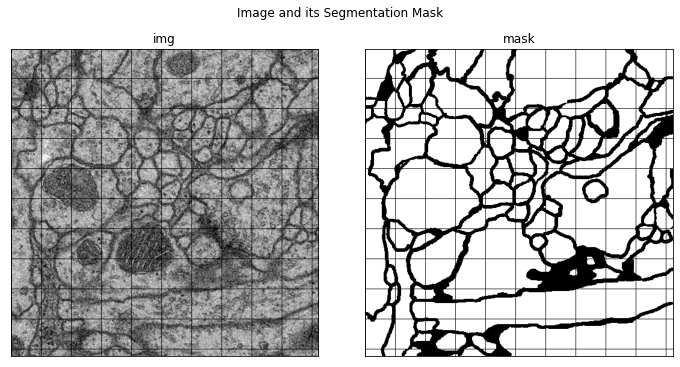

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(img, cmap="gray")
ax1.set_title("img")
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax2.imshow(mask, cmap="gray")
ax2.set_title("mask")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
fig.suptitle(t="Image and its Segmentation Mask", x=.5, y=1.)
plt.tight_layout()
plt.show()

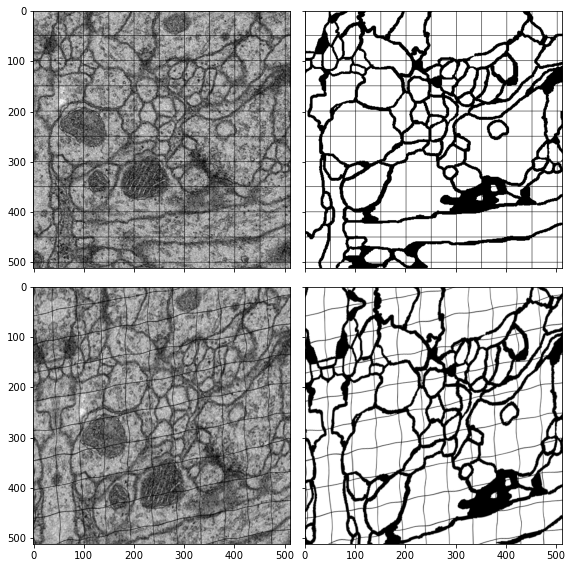

In [27]:
el_df_img, el_df_mask = custom_2d_elastic_deform(
    img, 
    mask, 
    alpha_affine=ALPHA_AFFINE, 
    sigma=SIGMA, 
    alpha=120.)

figname = "Image and Segmentation Mask Orignal and Elastic Deformed"
figname = os.path.join(RESULTS_PATH, f"{figname}.png")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
axes[0,0].imshow(img, cmap="gray")
# axes[0,0].set_title("Original Image")
# axes[0,0].get_xaxis().set_ticks([])
# axes[0,0].get_yaxis().set_ticks([])

axes[0,1].imshow(mask, cmap="gray")
# axes[0,1].set_title("Original Mask")
# axes[0,1].get_xaxis().set_ticks([])
# axes[0,1].get_yaxis().set_ticks([])

axes[1,0].imshow(el_df_img, cmap="gray")
# axes[1,0].set_title("Elastic Deformed Image")
# axes[1,0].get_xaxis().set_ticks([])
# axes[1,0].get_yaxis().set_ticks([])

axes[1,1].imshow(el_df_mask, cmap="gray")
# axes[1,1].set_title("Elastic Deformed Mask")
# axes[1,1].get_xaxis().set_ticks([])
# axes[1,1].get_yaxis().set_ticks([])

# fig.suptitle(t="Image and Segmentation Mask", x=.5, y=1.)
plt.tight_layout()
plt.savefig(figname)
plt.show()

## Model prediction and visualization

In [11]:
if DEVICE != "cpu":
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
unet = CustomUNet()
unet.load_state_dict(torch.load(os.path.join(MODEL_PATH, MODEL_NAME)))
unet.to(DEVICE)

CustomUNet(
  (encoder): UNetEncoder(
    (down): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
      (4): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(1024, 1024,

In [12]:
custom_test_dataset = CustomDataset(
    dataset=test_dataset, 
    image_transformations=image_transformations, 
    mask_transformations=mask_transformations)

custom_img, custom_mask = custom_test_dataset.__getitem__(i)
custom_img, custom_mask = custom_img.unsqueeze(dim=0), custom_mask.unsqueeze(dim=0)

output = unet(custom_img.to(DEVICE)).detach()
if DEVICE=="cuda":
    output = output.detach().cpu()    
output = process_output(output, threshold=OUTPUT_THRESHOLD)

In [13]:
custom_img = custom_img[0][0]
custom_mask = functional.pad(custom_mask, padding=94, fill=1)[0][0]
output = functional.pad(output, padding=94, fill=1.)[0][0]

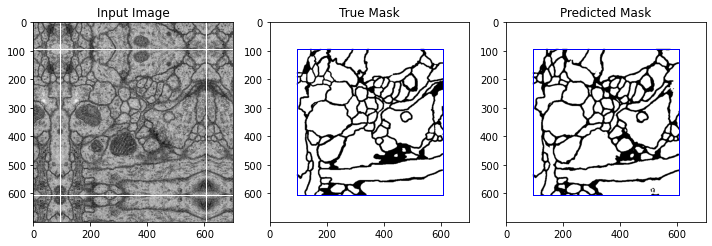

In [25]:
figname = "Image and Predicted Mask"
figname = os.path.join(RESULTS_PATH, f"{figname}.png")
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,4)) 

linewidth=1
ax1.imshow(custom_img, cmap="gray")
ax1.axhline(y=94, linewidth=linewidth, color="w")
ax1.axhline(y=94+512, linewidth=linewidth, color="w")
ax1.axvline(x=94, linewidth=linewidth, color="w")
ax1.axvline(x=94+512, linewidth=linewidth, color="w")
ax1.set_title("Input Image")

ax2.imshow(custom_mask, cmap="gray")
ax2.set_title("True Mask")
ax2.axhline(y=94, xmin=94/700, xmax=(94+512)/700, color="blue", linewidth=linewidth)
ax2.axhline(y=94+512, xmin=94/700, xmax=(94+512)/700, color="blue", linewidth=linewidth)
ax2.axvline(x=94, ymin=94/700, ymax=(94+512)/700, color="blue", linewidth=linewidth)
ax2.axvline(x=94+512, ymin=94/700, ymax=(94+512)/700, color="blue", linewidth=linewidth)

ax3.imshow(output, cmap="gray")
ax3.set_title("Predicted Mask")
ax3.axhline(y=94, xmin=94/700, xmax=(94+512)/700, color="blue", linewidth=linewidth)
ax3.axhline(y=94+512, xmin=94/700, xmax=(94+512)/700, color="blue", linewidth=linewidth)
ax3.axvline(x=94, ymin=94/700, ymax=(94+512)/700, color="blue", linewidth=linewidth)
ax3.axvline(x=94+512, ymin=94/700, ymax=(94+512)/700, color="blue", linewidth=linewidth)

plt.tight_layout()
plt.savefig(figname)
plt.show()

In [18]:
print(summary(CustomUNet(), torch.zeros((1, 1, 700, 700)), show_input=False, show_hierarchical=True))

------------------------------------------------------------------------------------------------------------------------------------------------------
      Layer (type)                                                                                       Output Shape         Param #     Tr. Param #
     UNetEncoder-1     [1, 1024, 36, 36], [1, 64, 696, 696], [1, 128, 344, 344], [1, 256, 168, 168], [1, 512, 80, 80]      18,842,048      18,842,048
     UNetDecoder-2                                                                                  [1, 64, 516, 516]      12,188,480      12,188,480
          Conv2d-3                                                                                  [1, 64, 514, 514]          36,928          36,928
            ReLU-4                                                                                  [1, 64, 514, 514]               0               0
          Conv2d-5                                                                                 

In [17]:
np.unique(img, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

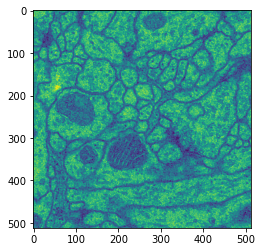

In [15]:
plt.imshow(img)